# Pattern Generation
[![pattern_generation.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_generation.ipynb)](https://ampl.com)

Description: Pattern generation example with amplpy

Tags: amplpy, example

Notebook author: Filipe Brand√£o <<fdabrandao@gmail.com>>

Model author: N/A

References: N/A

In [1]:
# Install dependencies
%pip install -q amplpy matplotlib numpy

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Basic pattern-cutting model

In [3]:
%%ampl_eval
param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;

## Plotting routine

In [4]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt

    ind = np.arange(len(solution))
    acc = [0] * len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0] * len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title("Solution")
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

## Set data

In [5]:
roll_width = 64.5
overrun = 6
orders = {6.77: 10, 7.56: 40, 17.46: 33, 18.76: 10}
widths = list(sorted(orders.keys(), reverse=True))

## Send data to AMPL (Java/C++ style)

In [6]:
from math import floor

# Send scalar values
ampl.get_parameter("overrun").set(overrun)
ampl.get_parameter("nPatterns").set(len(widths))
# Send order vector
ampl.get_set("WIDTHS").set_values(widths)
ampl.get_parameter("order").set_values(orders)
# Generate and send initial pattern matrix
ampl.get_parameter("rolls").set_values(
    {(widths[i], 1 + i): int(floor(roll_width / widths[i])) for i in range(len(widths))}
)

## Send data to AMPL (alternative style)

In [7]:
# Send scalar values
ampl.param["overrun"] = overrun
ampl.param["nPatterns"] = len(widths)
# Send order vector
ampl.set["WIDTHS"] = widths
ampl.param["order"] = orders
# Generate and send initial pattern matrix
ampl.param["rolls"] = {
    (widths[i], 1 + i): int(floor(roll_width / widths[i])) for i in range(len(widths))
}

## Set up for generation loop

In [8]:
# Set solve options
ampl.option["relax_integrality"] = 1

# Create a param for sending AMPL new patterns
ampl.eval("param newpat {WIDTHS} integer >= 0;")
new_pattern = ampl.param["newpat"]

## Define the knapsack subproblem

In [9]:
# Define the knapsack subproblem
subprob = AMPL()
subprob.eval(
    """
    set WIDTHS;
    param W >= 0;
    param v{WIDTHS} >= 0;
    var x{WIDTHS} integer >= 0;
    maximize profit: sum {w in WIDTHS} v[w]*x[w];
    subject to capacity: sum {w in WIDTHS} w*x[w] <= W;
"""
)
subprob.set["WIDTHS"] = widths
subprob.param["W"] = roll_width
values = subprob.param["v"]
kpsolution = subprob.var["x"]
profit = subprob.obj["profit"]

## Loop

In [10]:
limits = ampl.get_constraint("FinishedRollLimits")
while True:
    print("Master problem:")
    ampl.solve(solver="gurobi")
    assert ampl.solve_result == "solved", ampl.solve_result

    # Retrieve duals & look for new pattern
    # Solve knapsack problem for potential new pattern
    values.set_values(limits.get_values())
    print("\nSubproblem:")
    subprob.solve(solver="gurobi")
    assert subprob.solve_result == "solved", subprob.solve_result
    print()
    if profit.value() <= 1.000001:
        break

    # Send new pattern to AMPL
    new_pattern.set_values(kpsolution.get_values())
    ampl.eval("let nPatterns := nPatterns + 1;")
    ampl.eval("let {w in WIDTHS} rolls[w, nPatterns] := newpat[w];")

Master problem:
Gurobi 9.5.0: optimal solution; objective 20.44444444

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.152777778
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 18.77777778
1 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.111111111

Master problem:
Gurobi 9.5.0: optimal solution; objective 18.375
3 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.125
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 17.95833333
5 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.041666667
2 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 17.94117647
5 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1
1 simplex iterations
1 branch-and-cut nodes



## Compute and display integer solution

Gurobi 9.5.0: optimal solution; objective 19
5 simplex iterations
1 branch-and-cut nodes
[0.0, 0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 1.0]


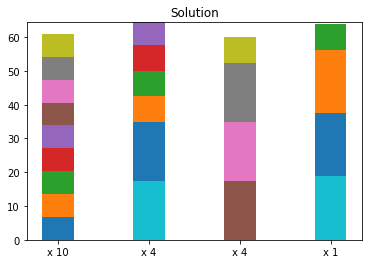

In [11]:
# Compute and display integer solution
ampl.option["relax_integrality"] = 0
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result

# Retrieve solution
cutvec = ampl.var["Cut"].to_list(skip_index=True)

# Display solution
rolls = ampl.param["rolls"]
npatterns = int(ampl.param["nPatterns"].value())
solution = [
    ([int(rolls[widths[i], p]) for i in range(len(widths))], int(cutvec[p]))
    for p in range(npatterns)
    if cutvec[p] > 0
]
cuttingPlot(roll_width, widths, solution)